<a href="https://colab.research.google.com/github/UthamanA/NYC-Taxi-trip-time-Prediction---capstone-project/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>




## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

So let's first mount the drive to load our dataset.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Exploratory Data Analysis**

Now let's import all the important libraries that we'll be using for ou

In [3]:

# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import xgboost
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import warnings
from pylab import rcParams
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
warnings.filterwarnings('ignore')

**After that let us fetch the data obviously.**

Working without data is like making a cake without bread.

In [4]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC Taxi Trip Time Prediction/NYC Taxi Data.csv')

Checking the shape so we get an idea of how many rows and features we have

In [5]:
df.shape

(1458644, 11)


That's quite alot i believe we will need to remove all the outliers and decrease the data as well.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Some observations about the columns are :

**pickup_datetime** and **pickup_datetime** are in string format that are to be converted into datetime format.
**store_and_fwd_flag** is a categorical variable.

In [7]:
df.head()


id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

Typically in our world a taxi company always faces issues to provide best facilities to the customers.

Here we are presented with data which consists of alot of taxi trips. Now, here we will try to apply many techniques to understand and explore the data that is provided to us.

In [8]:
df.describe()

vendor_id  passenger_count  ...  dropoff_latitude  trip_duration
count  1.458644e+06     1.458644e+06  ...      1.458644e+06   1.458644e+06
mean   1.534950e+00     1.664530e+00  ...      4.075180e+01   9.594923e+02
std    4.987772e-01     1.314242e+00  ...      3.589056e-02   5.237432e+03
min    1.000000e+00     0.000000e+00  ...      3.218114e+01   1.000000e+00
25%    1.000000e+00     1.000000e+00  ...      4.073588e+01   3.970000e+02
50%    2.000000e+00     1.000000e+00  ...      4.075452e+01   6.620000e+02
75%    2.000000e+00     2.000000e+00  ...      4.076981e+01   1.075000e+03
max    2.000000e+00     9.000000e+00  ...      4.392103e+01   3.526282e+06

[8 rows x 7 columns]

So from here we can see that:

Pasenger count varies from 0 to 9.
Trip duration has max value of 3526282 seconds almost 979.5 hours and minimum 1 second. This definetly has outliers present so we'll remove them.

After the basic analysis of our data we can see we have some outliers. Now let's chek if there isany null data.

In [9]:
df['trip_duration'].isnull().sum()

0

Thankfully there consists of no null data. Now moving forward let's remove all the duplicates present in the dataset.

In [10]:
df.drop_duplicates(inplace=True)
df.shape

(1458644, 11)


Now let's start analysing all the features(columns) one by one as Malcolm Bradbury has stated

Culture is a way of coping with the world by defining it in detail.

In [11]:
df['passenger_count'].value_counts().reset_index()

index  passenger_count
0      1          1033540
1      2           210318
2      5            78088
3      3            59896
4      6            48333
5      4            28404
6      0               60
7      7                3
8      9                1
9      8                1

As we can see the number of passengers varies from 0 to 9.

In [12]:
df[df['passenger_count']==0].count()

id                    60
vendor_id             60
pickup_datetime       60
dropoff_datetime      60
passenger_count       60
pickup_longitude      60
pickup_latitude       60
dropoff_longitude     60
dropoff_latitude      60
store_and_fwd_flag    60
trip_duration         60
dtype: int64


Dropping all the data with zero passengers in it as we can't really say anything about the taxi which already has no passenger in it.

In [13]:
df=df[df['passenger_count']!=0]

Now let's get back to our date time data and handle it

In [14]:
df["pickup_datetime"][0]

'2016-03-14 17:24:55'

Converting it from the string format to date time format and saving it in the row itself

In [15]:
df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])
df.head()

id  vendor_id  ... store_and_fwd_flag trip_duration
0  id2875421          2  ...                  N           455
1  id2377394          1  ...                  N           663
2  id3858529          2  ...                  N          2124
3  id3504673          2  ...                  N           429
4  id2181028          2  ...                  N           435

[5 rows x 11 columns]

As we all know graphs are like a backbone of any data analyst and without them it is very difficult for normal people to figure out what we have done in our Data Analysis so let's start plotting some graphs. As it was rightly

Now as we know that our target variable which is trip_duration have some outliers as well now let's plot it's graph.

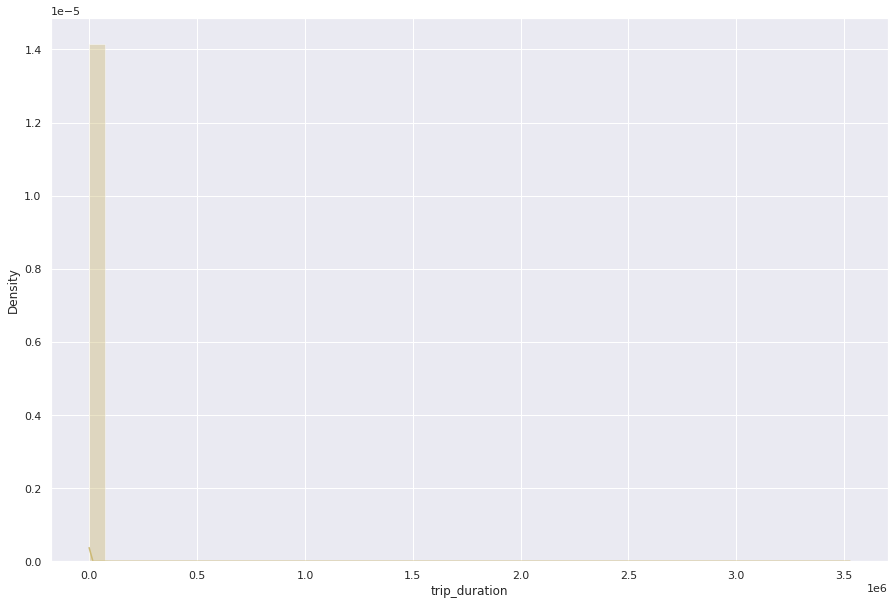

In [16]:
# Dependent variable 'trip_duration'
plt.figure(figsize=(15,10))
sns.distplot(df['trip_duration'],color="y")

So we can see there is some skweness in our data. Trip duration is left skewed so handling it by using log transformation to normalize the data.

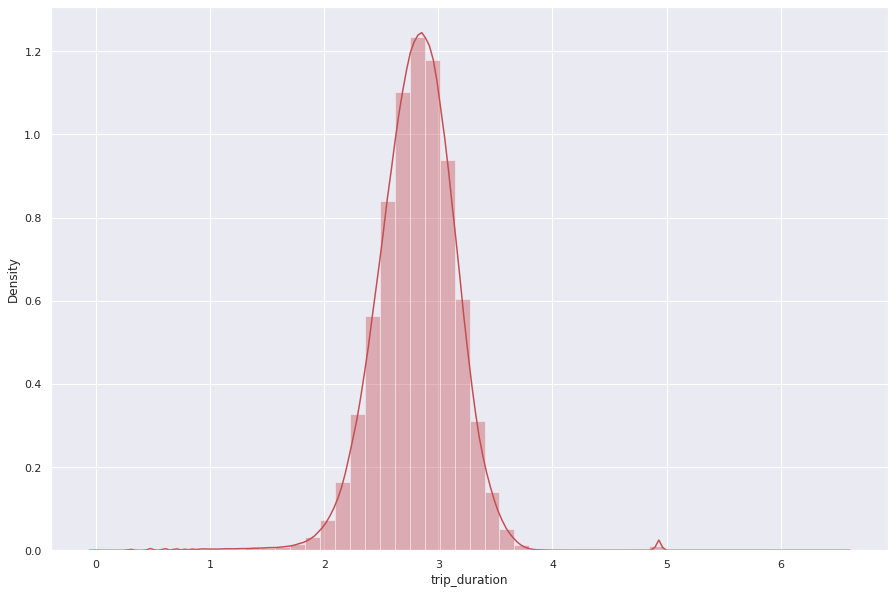

In [17]:
plt.figure(figsize=(15,10))
sns.distplot(np.log10(df['trip_duration']),color="R")


Now let's have a look at our numerical features and make a box plot to see how many outliers do they contain

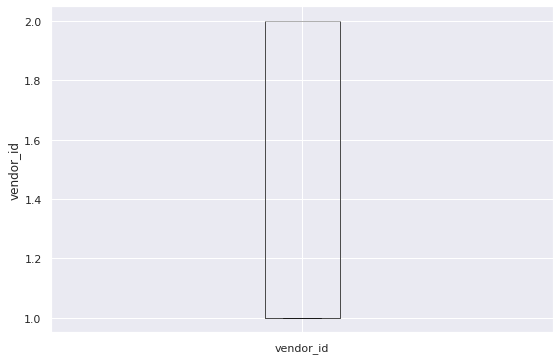

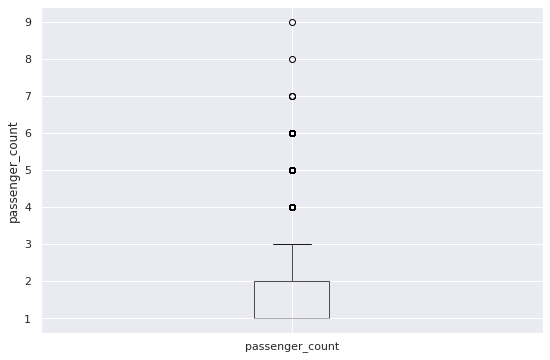

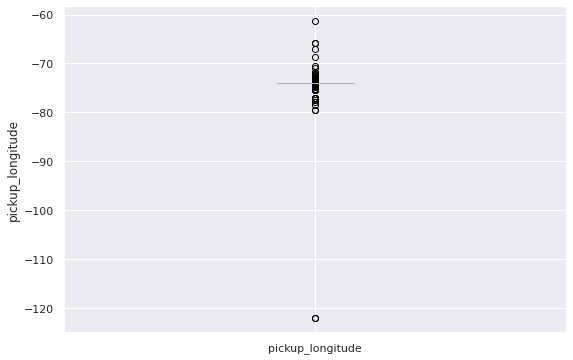

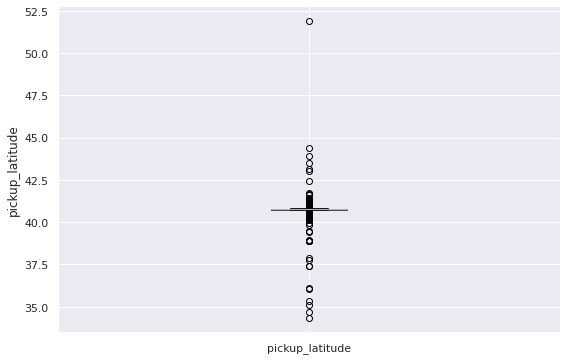

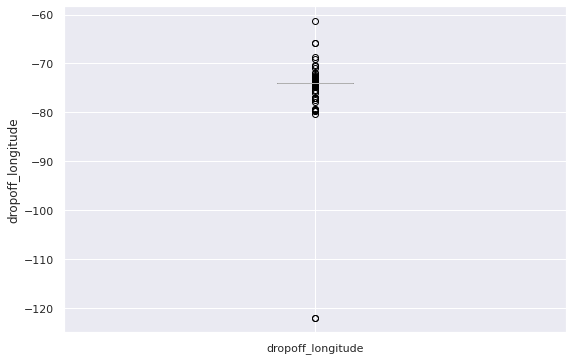

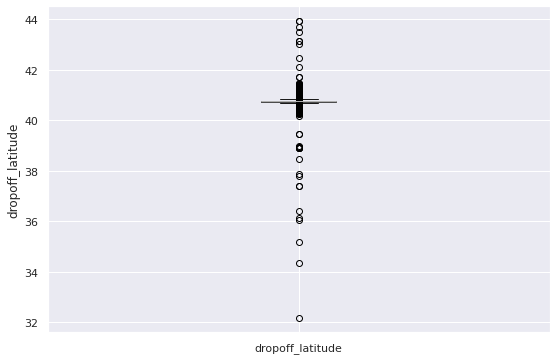

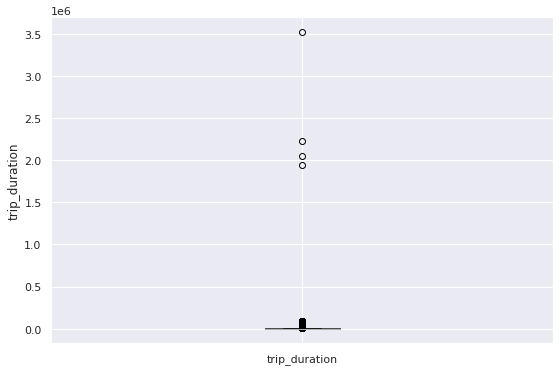

In [18]:
# plot a boxplot for the label by each numerical feature  
for col in df.describe().columns:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  df.boxplot(column = col, ax = ax)
  ax.set_ylabel(col)
plt.show()

Okay so what we know now :

Vendor ID has no outlier.

In passenger count 4 and more passengers are being treated as outliers.

pickup_longitude and pickup_latitude has outliers as well.

dropoff_longitude and dropoff_latitude has outliers too.

Our target variable trip_duration has alot of outliers

Now it's time for our white blood cells to get in action and remove these outliers. So our Outlier treatment will be using **IQR(inter-quartile range)** method

In [19]:
numeric_features = df.describe().columns
numeric_features

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_duration'],
      dtype='object')

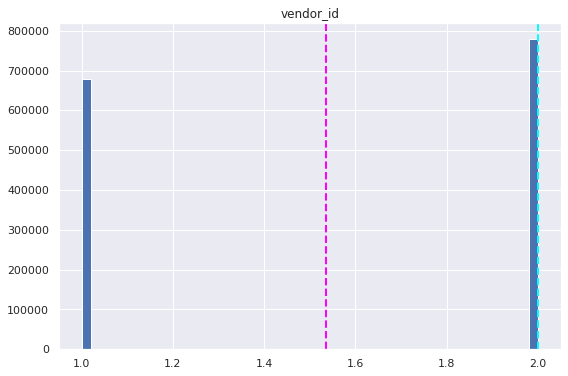

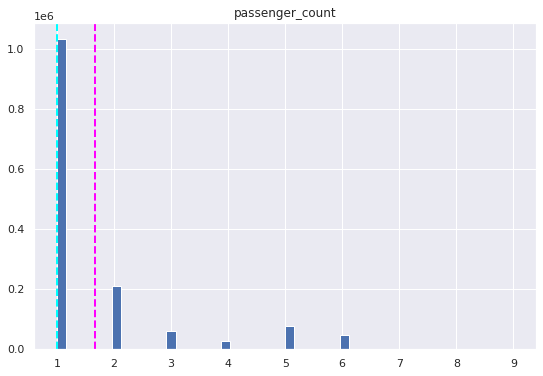

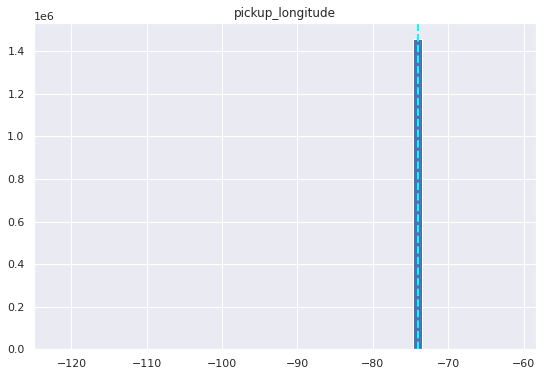

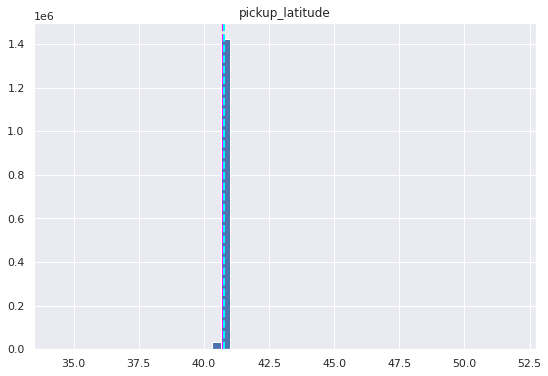

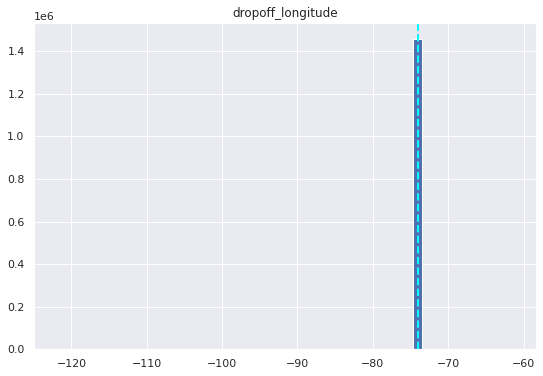

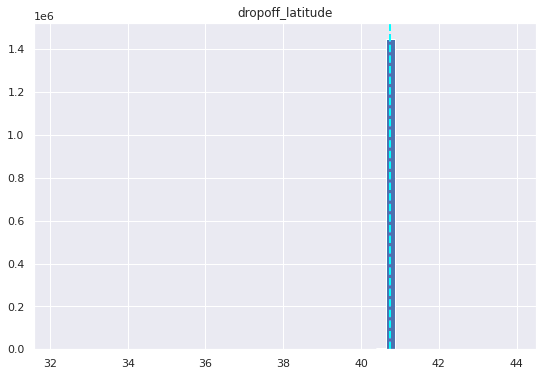

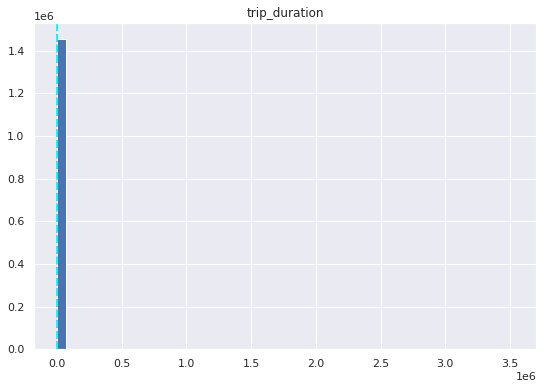

In [20]:
# plot a bar plot for each numerical feature count
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()


Let us aslo plot a scatter plot as well to get more understanding of our feature

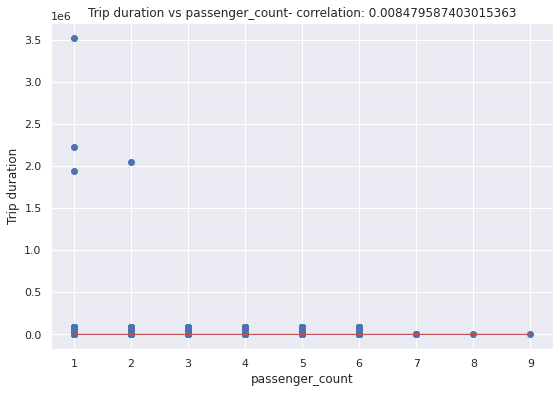

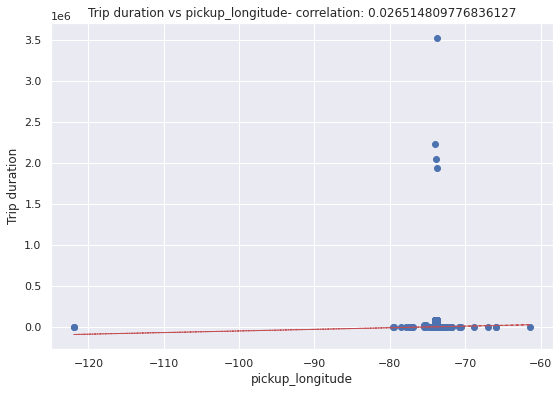

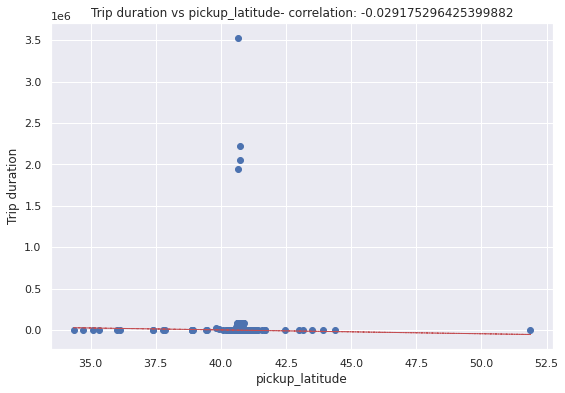

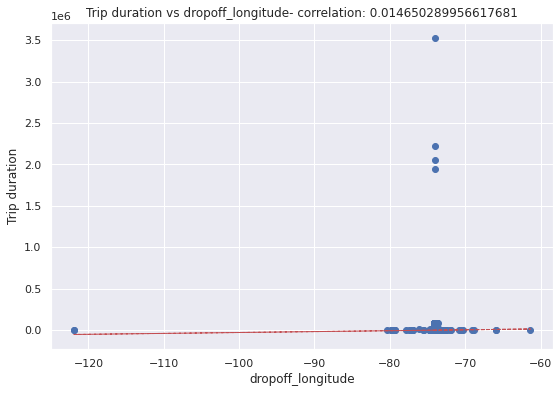

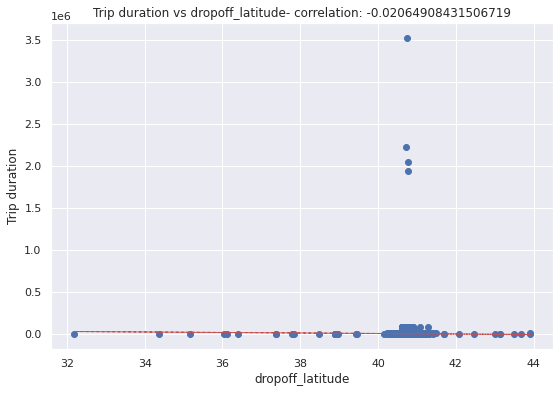

In [21]:
for col in numeric_features[1:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['trip_duration']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Trip duration')
    ax.set_title('Trip duration vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(df[col], df['trip_duration'], 1)
    y_hat = np.poly1d(z)(df[col])

    plt.plot(df[col], y_hat, "r--", lw=1)

plt.show()

We were working on a dataset with taxi don't forget that we all kow sometimes when we start thinking too deply we tend to forget what we were doing so let's work with latitude and longitude which we have.

**Here we will plot a scatter plot of pickup and dropoff locations.**

Text(0.5, 1.0, 'Dropoff')

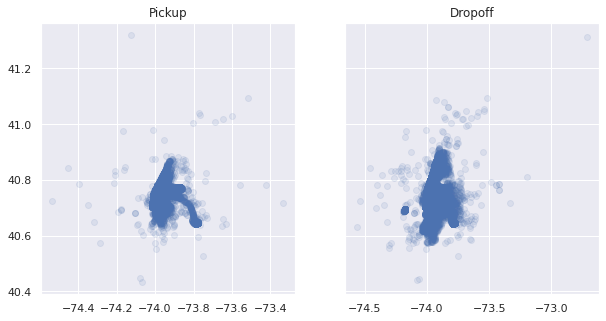

In [22]:
#plot to see the differences - minimal, but there is some change
n = 100000 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax1.scatter(df.pickup_longitude[:n], 
            df.pickup_latitude[:n],
            alpha = 0.1)
ax1.set_title('Pickup')
ax2.scatter(df.dropoff_longitude[:n], 
            df.dropoff_latitude[:n],
            alpha = 0.1)
ax2.set_title('Dropoff')


Let us try to atleast see what places were booked the most using our political and geographical maps. We know everyone loves maps so let's



In [23]:
def select_within_boundingbox(df, BB):
    return ((df["pickup_longitude"] >= BB[0]) & (df["pickup_longitude"] <= BB[1]) & 
            (df["pickup_latitude"] >= BB[2]) & (df["pickup_latitude"] <= BB[3]) &
            (df["dropoff_longitude"] >= BB[0]) & (df["dropoff_longitude"] <= BB[1]) &
            (df["dropoff_latitude"] >= BB[2]) & (df["dropoff_latitude"] <= BB[3]))
BB = (-74.3, -73.0, 40.6, 41.7)

In [24]:
nyc_map1 = plt.imread('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC.webp')
nyc_map2 = plt.imread('/content/drive/MyDrive/Capstone Project/cap pro 2 - Supervised ML - Regression/NYC.jpg')

In [25]:
df = df[select_within_boundingbox(df, BB)]
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1,2,figsize=(13, 8))
    axs[0].scatter(df["pickup_longitude"], df["pickup_latitude"], alpha = alpha, c='g', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup Locations')
    axs[0].imshow(nyc_map, extent=BB)
    
    axs[1].scatter(df["dropoff_longitude"], df["dropoff_latitude"] , alpha = alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff Locations')
    axs[1].imshow(nyc_map, extent=BB)

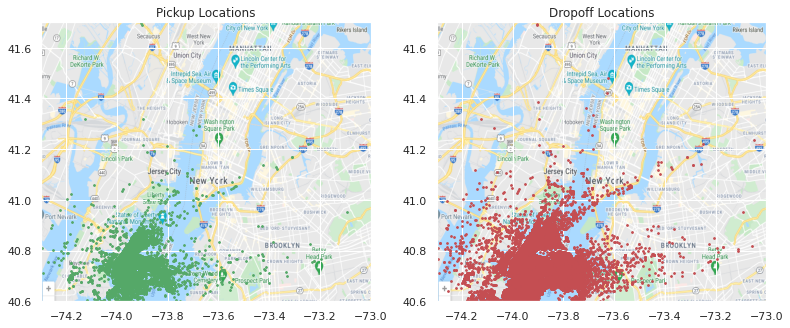

In [26]:
plot_on_map(df, BB, nyc_map1, s=3, alpha=1)

Plotting the pickup and drop off locations on political map (zoomed out)


In [27]:
import folium
f = folium.Figure(width=1500, height=500)
mapa = folium.Map(location = (40.7679, -73.9822), zoom_start=11).add_to(f)

for index, row in df.sample(1000).iterrows():
    folium.Marker([row["pickup_latitude"], row["pickup_longitude"]], icon=folium.Icon(color="blue")).add_to(mapa)
    folium.Marker([row["dropoff_latitude"], row["dropoff_longitude"]], icon=folium.Icon(color="red")).add_to(mapa)
display(mapa)

So now let's do some feature engineering as we know what EDA have we even done unless we don't do some feature engineering.

#**Feature Engineering**

As we have converted our date time column into manipulative form now let's make use of it to explore the data and let it help the model run better.

We will make new columns for days of the week of their corresponging pickup and drop-off day

In [28]:
df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()
df.head()

id  vendor_id  ... pickup_day dropoff_day
0  id2875421          2  ...     Monday      Monday
1  id2377394          1  ...     Sunday      Sunday
2  id3858529          2  ...    Tuesday     Tuesday
3  id3504673          2  ...  Wednesday   Wednesday
4  id2181028          2  ...   Saturday    Saturday

[5 rows x 13 columns]


After this we will now let's try to visualise our data and see which day has been the busiest for our hard working taxi drivers

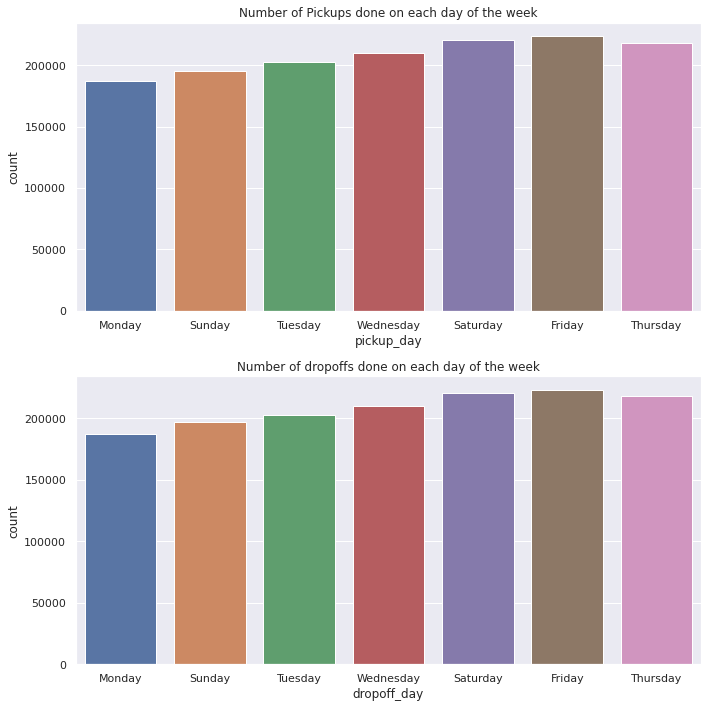

In [29]:
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(10,10))
sns.countplot(x='pickup_day',data=df,ax=ax[0])
ax[0].set_title('Number of Pickups done on each day of the week')
sns.countplot(x='dropoff_day',data=df,ax=ax[1])
ax[1].set_title('Number of dropoffs done on each day of the week')
plt.tight_layout()

**Thus we see most trips were taken on Friday and Monday being the least. The distribution of trip duration with the days of the week is something to look into as well.**

Well it actually makes sense because most people will want to go out and enjoy their weekends partying and noone will have time to do that on a Monday. As everyone needs to earn the money back which was spent on Friday while parying.

Okay so as we have our days now let's also try to figure out the time and see what time was the busiest and what is least busiest.

**The distribution of Pickup and Drop Off hours of the day**

The time part is represented by hours,minutes and seconds which is difficult for the analysis thus we divide the times into 4 time zones:

**Morning** (4 hrs to 10 hrs)

**Midday** (10 hrs to 16 hrs)

**Evening** (16 hrs to 22 hrs)

**Late night** (22 hrs to 4 hrs)

In [30]:
bins=np.array([0,1800,3600,5400,7200,90000])
df['duration_time']=pd.cut(df.trip_duration,bins,labels=["< 5", "5-10", "10-15","15-20",">20"])

In [31]:
import datetime
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

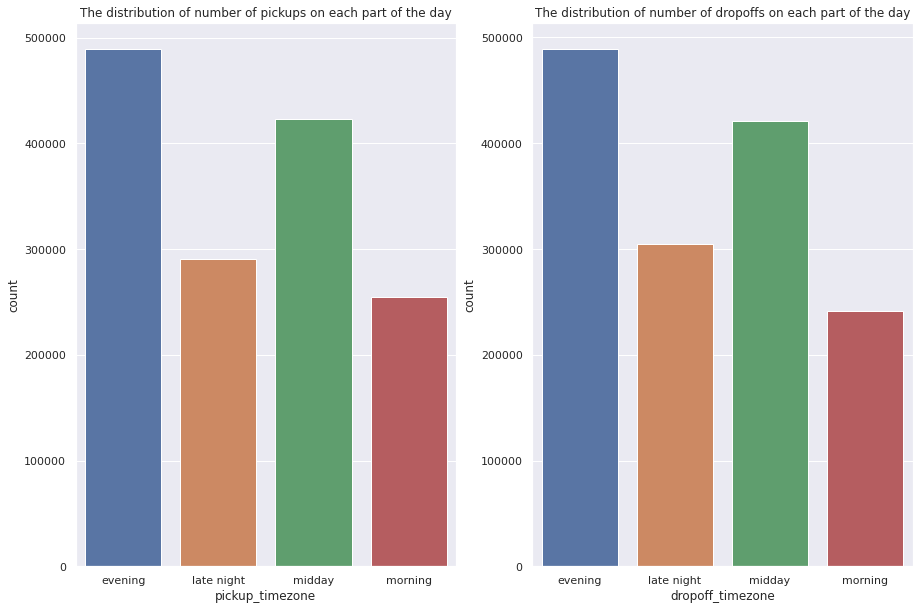

In [32]:
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,10))
sns.countplot(x='pickup_timezone',data=df,ax=ax[0])
ax[0].set_title('The distribution of number of pickups on each part of the day')
sns.countplot(x='dropoff_timezone',data=df,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs on each part of the day')
plt.show()

So now we can see that our taxi's were booked in the evening most and midday following it while very less people travel in the morning as compared.

Text(0.5, 1.0, 'The Distribution of percentage of different duration of trips')

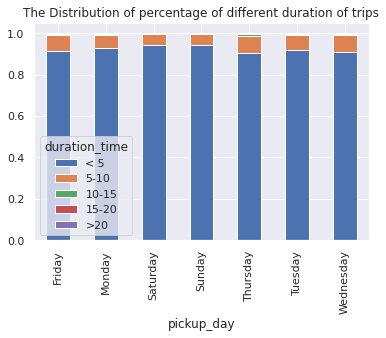

In [33]:
ax1=df.groupby('pickup_day')['duration_time'].value_counts(normalize=True).unstack()
ax1.plot(kind='bar', stacked='True')
plt.title('The Distribution of percentage of different duration of trips')

Now we have worked enough on the time zones and days of the week now let's start working with a new varibale. So we know we have a longitude and latitude present so we will work on it to make a new feature that is distance.

**So making a new distance column from the latitude and longitude**

In [34]:
from math import sin, cos, sqrt, atan2, radians

def get_distance(lon_1, lon_2, lat_1, lat_2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat_1)
    lon1 = radians(lon_1)
    lat2 = radians(lat_2)
    lon2 = radians(lon_2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return distance

In [35]:
df["distance"] = df.apply(lambda x: get_distance(x["pickup_longitude"],x["dropoff_longitude"],x["pickup_latitude"],x["dropoff_latitude"]),axis=1)

#**IQR=Q3-Q1**

lower_limit_outlier=Q1-1.5*IQR 
upper_limit_outlier=Q3+1.5*IQR

so we have to take the values which is greater then lower limit outlier and less then upper limit outlier

remove the outlier present in distance

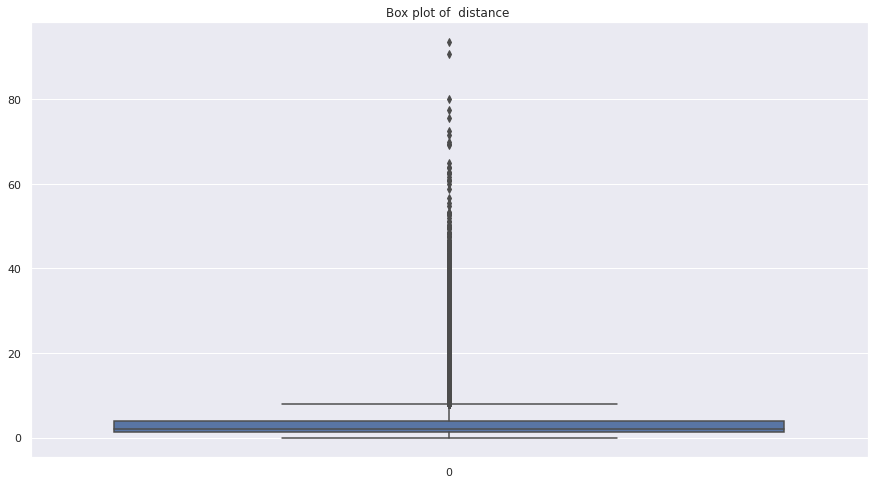

In [36]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  distance ")
ax = sns.boxplot(data=df['distance'], orient="v")

In [37]:
percentile_q1 = np.percentile(df['distance'],25)
print(percentile_q1)
percentile_q2 = np.percentile(df['distance'],50)
print(percentile_q2)
percentile_q3 = np.percentile(df['distance'],75)
print(percentile_q3)

1.2318911479050365
2.092759918422096
3.869440610255646


In [38]:
iqr=percentile_q3 - percentile_q1
lower_limit_outlier=percentile_q1-1.5*iqr
upper_limit_outlier=percentile_q3+1.5*iqr

In [39]:
print("lower limit for outlier  :",lower_limit_outlier)
print("Upper limit for outlier  :",upper_limit_outlier)

lower limit for outlier  : -2.724433045620877
Upper limit for outlier  : 7.82576480378156


In [40]:
df=df[df['distance']>lower_limit_outlier]
df=df[df['distance']<upper_limit_outlier]

In [41]:

df.shape

(1317293, 17)

remove the outlier present in trip_duration



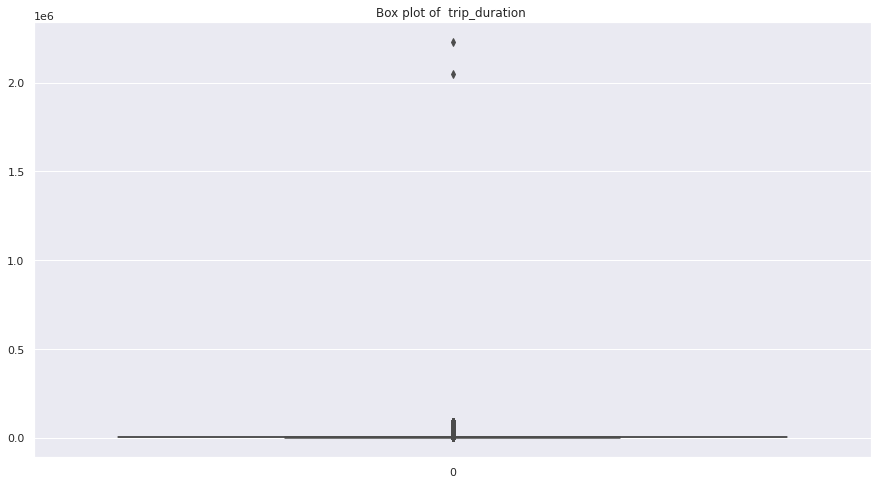

In [42]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  trip_duration ")
ax = sns.boxplot(data=df['trip_duration'], orient="v")

In [43]:
percentile_q1_trip_duration = np.percentile(df['trip_duration'],25)
print(percentile_q1_trip_duration)
percentile_q2_trip_duration = np.percentile(df['trip_duration'],50)
print(percentile_q2_trip_duration)
percentile_q3_trip_duration = np.percentile(df['trip_duration'],75)
print(percentile_q3_trip_duration)

373.0
605.0
931.0


In [44]:
iqr=percentile_q3_trip_duration - percentile_q1_trip_duration
lower_limit_outlier_trip_duration=percentile_q1_trip_duration-1.5*iqr
upper_limit_outlier_trip_duration=percentile_q3_trip_duration+1.5*iqr

In [45]:
print("lower limit for outlier  :",lower_limit_outlier_trip_duration)
print("Upper limit for outlier  :",upper_limit_outlier_trip_duration)

lower limit for outlier  : -464.0
Upper limit for outlier  : 1768.0


In [46]:
df=df[df['trip_duration']>0]
df=df[df['trip_duration']<upper_limit_outlier_trip_duration]

In [47]:
df.shape

(1276847, 17)

remove the outlier present in passenger_count

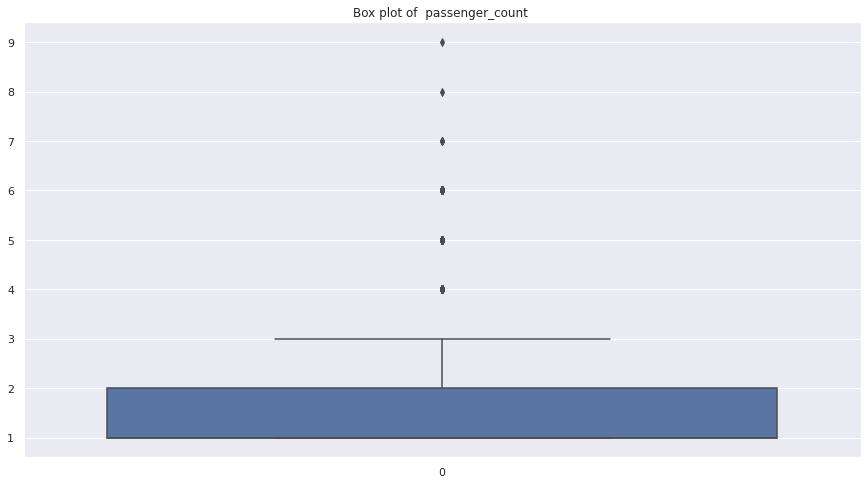

In [48]:
plt.figure(figsize=(15,8))
plt.title("Box plot of  passenger_count ")
ax = sns.boxplot(data=df['passenger_count'], orient="v")

In [49]:
percentile_q1_passenger_count = np.percentile(df['passenger_count'],25)
print(percentile_q1_passenger_count)
percentile_q2_passenger_count = np.percentile(df['passenger_count'],50)
print(percentile_q2_passenger_count)
percentile_q3_passenger_count = np.percentile(df['passenger_count'],75)
print(percentile_q3_passenger_count)

1.0
1.0
2.0


In [50]:
iqr=percentile_q3_passenger_count - percentile_q1_passenger_count
lower_limit_outlier_passenger_count=percentile_q1_passenger_count-1.5*iqr
upper_limit_outlier_passenger_count=percentile_q3_passenger_count+1.5*iqr

In [51]:
print("lower limit for outlier  :",lower_limit_outlier_passenger_count)
print("Upper limit for outlier  :",upper_limit_outlier_passenger_count)

lower limit for outlier  : -0.5
Upper limit for outlier  : 3.5


In [52]:
df=df[df['passenger_count']>0]
df=df[df['passenger_count']<upper_limit_outlier_passenger_count]

In [53]:
df.shape

(1142158, 17)

In [54]:
df.head()

id  vendor_id  ... dropoff_timezone  distance
0  id2875421          2  ...          evening  1.498991
1  id2377394          1  ...       late night  1.806074
3  id3504673          2  ...          evening  1.485965
4  id2181028          2  ...           midday  1.188962
7  id1324603          2  ...          morning  5.716775

[5 rows x 17 columns]

In [55]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"], format="%Y-%m-%d %H:%M:%S")

In [56]:
df['Day']=df['pickup_datetime'].dt.day_name()

In [57]:
df["year"] = df["pickup_datetime"].apply(lambda x: x.year)
df["month"] = df["pickup_datetime"].apply(lambda x: x.month)
df["day_num"] = df["pickup_datetime"].apply(lambda x: x.day)
df["hour"] = df["pickup_datetime"].apply(lambda x: x.hour)
df["minute"] = df["pickup_datetime"].apply(lambda x: x.minute)


Finally let's start picking up the pace and do more feature engineering :

Converting trip duration into hours.

Taking log of our distance for normalisation of data.

Taking log of our trip duration as well to normalize it's data too.

In [58]:
df['trip_duration_hour']=df['trip_duration']/3600
df['log_distance']=np.log(df.distance)
df['log_trip_duration']=np.log(df.trip_duration_hour)

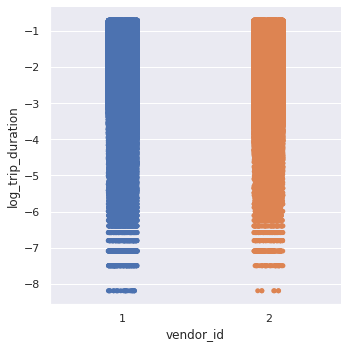

In [59]:

sns.catplot(x="vendor_id", y="log_trip_duration",kind="strip",data=df)

**Here we see that vendor 1 mostly provides short trip duration cabs while vendor 2 provides cab for both short and long trips**

So now let's plot the relatioship of store_and_fwd_flag and our trip_duration

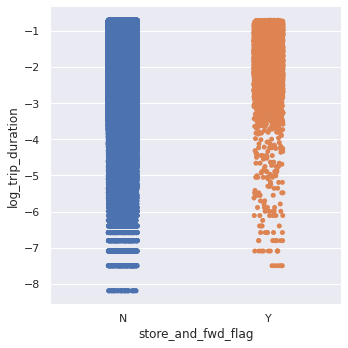

In [60]:
sns.catplot(x="store_and_fwd_flag", y="log_trip_duration",kind="strip",data=df)


Now let's make some verses graph and plot the distance time graph

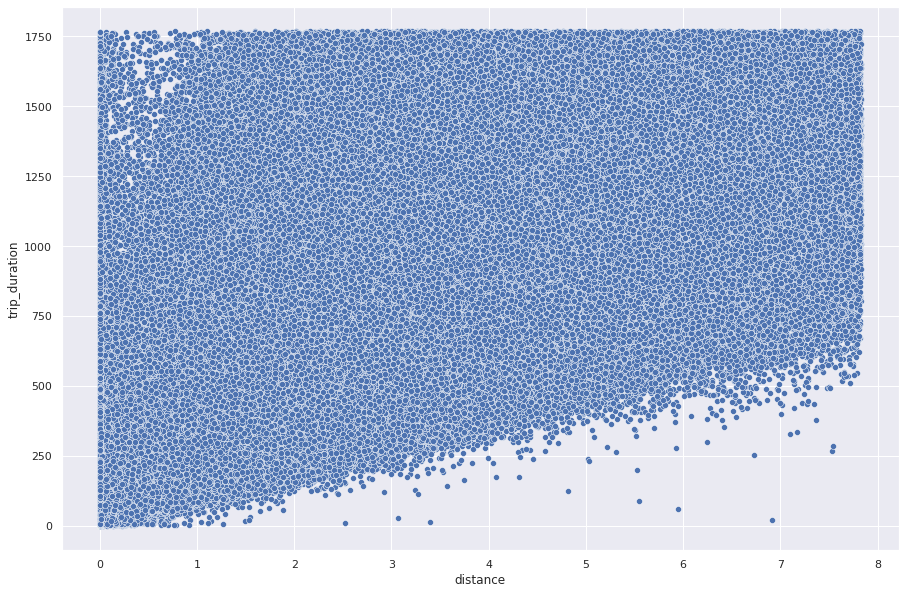

In [61]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='distance',y='trip_duration',data=df)

Okay this seems a bit disappointing so let's use the normalized data instead and use log features we added earlier to have a normalized data graph of trip duration and distance

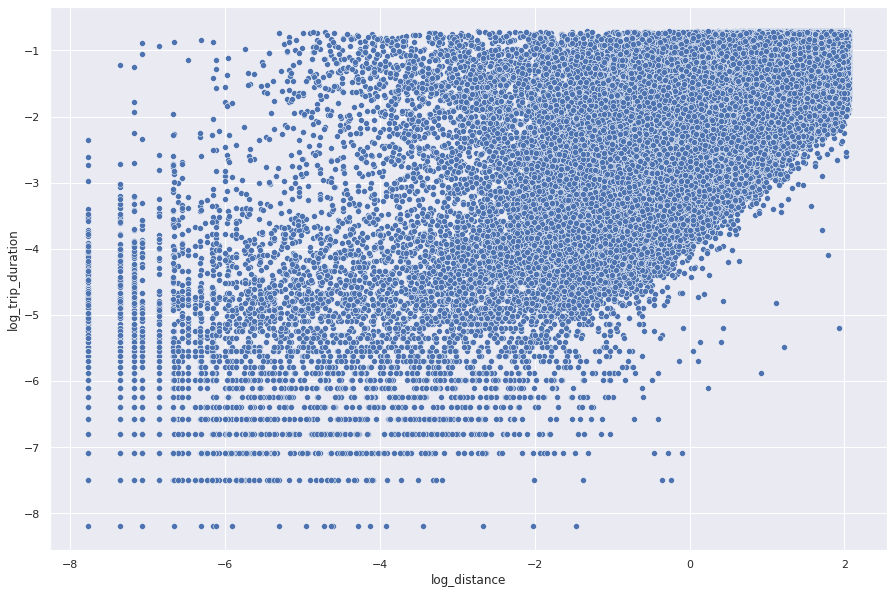

In [62]:
fig = plt.figure(figsize=(15, 10))
sns.scatterplot(x='log_distance',y='log_trip_duration',data=df)

Now we will see the difference between the original data and our normalized data

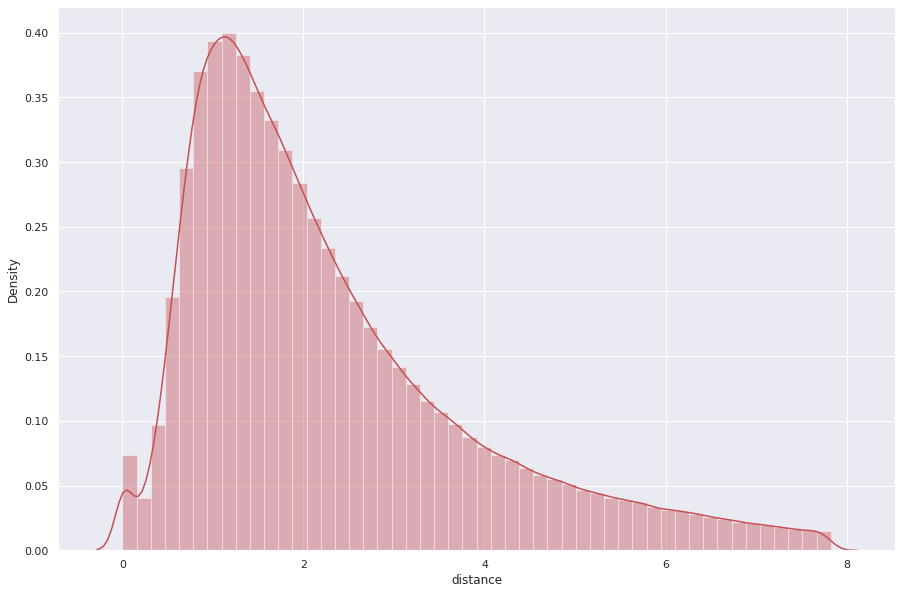

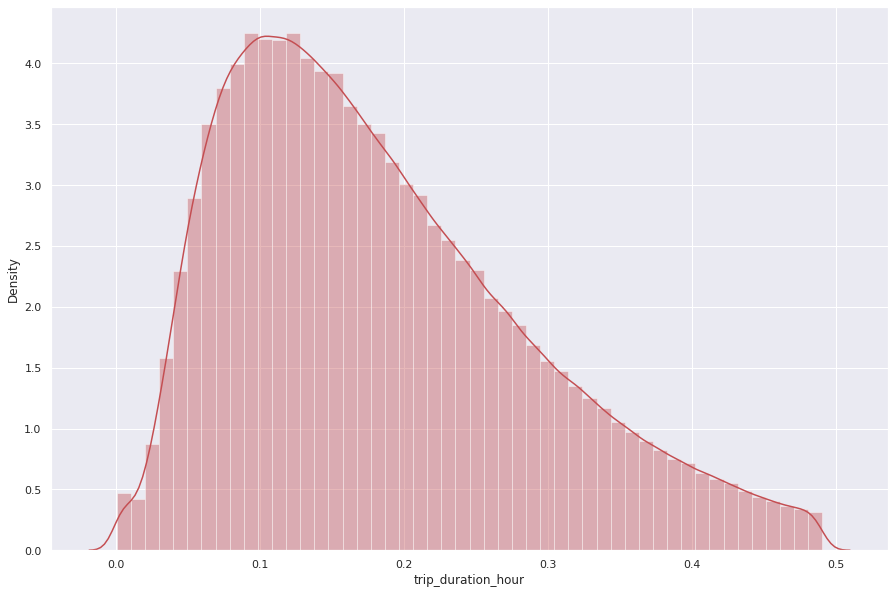

In [63]:
sample=['distance','trip_duration_hour']
for i in sample:
  plt.figure(figsize=(15,10))
  sns.distplot(df[i],color="R")


So for now we have only been focusing on mostly numerical features, now let's turn our gaze upon the categorical features too

#**One Hot Encoding**

In [64]:
# One hot encoding
df= pd.get_dummies(df, columns=["store_and_fwd_flag", "Day"], prefix=["store_and_fwd_flag",'Day'])

In [65]:

df.head()

id  vendor_id  ... Day_Tuesday Day_Wednesday
0  id2875421          2  ...           0             0
1  id2377394          1  ...           0             0
3  id3504673          2  ...           0             1
4  id2181028          2  ...           0             0
7  id1324603          2  ...           0             0

[5 rows x 33 columns]

In [66]:
features=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday']

In [67]:
newdata=['vendor_id','passenger_count','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','distance','month','hour','minute',
          'store_and_fwd_flag_N','store_and_fwd_flag_Y','Day_Friday','Day_Monday','Day_Saturday','Day_Sunday','Day_Thursday','Day_Tuesday','Day_Wednesday','trip_duration_hour']
trip_df=df[newdata]

In [68]:

from scipy.stats import zscore
#Train test split
# numeric_cols = carprice.select_dtypes(include=[np.number]).columns
X = df[features].apply(zscore)[:100000]
y=df['trip_duration_hour'][:100000]

In [69]:

X[:5]

vendor_id  passenger_count  ...  Day_Tuesday  Day_Wednesday
0   1.026266         -0.47367  ...    -0.402343      -0.409483
1  -0.974406         -0.47367  ...    -0.402343      -0.409483
3   1.026266         -0.47367  ...    -0.402343       2.442103
4   1.026266         -0.47367  ...    -0.402343      -0.409483
7   1.026266         -0.47367  ...    -0.402343      -0.409483

[5 rows x 19 columns]

#**Before Fitting data into our models lets split the into train and test dataset**

It is a fast and easy procedure to perform, the results of which allows us to compare the performance of our taxi trip duration prediction for.

Although simple to use and interpret, there are times when the procedure should not be used, such as when you have a small dataset and situations where additional configuration is required but we definetly not have a small dataset.

In [70]:
# Importing train_test_split
from sklearn.model_selection import train_test_split

In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [72]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(80000, 19) (80000,)
(20000, 19) (20000,)



#**Linear Regression**

For linear regression we have some assumptions, given below are the basic assumptions that a linear regression model makes regarding a dataset on which it is applied:

**Linear relationship:** Relationship between response and feature variables should be linear. The linearity assumption can be tested using scatter plots.

**Little or no multi-collinearity:** It is assumed that there is little or no multicollinearity in the data. Multicollinearity occurs when the features (or independent variables) are not independent from each other.

**Little or no auto-correlation:** Another assumption is that there is little or no autocorrelation in the data. Autocorrelation occurs when the residual errors are not independent from each other.

**Homoscedasticity:** Homoscedasticity describes a situation in which the error term (that is, the “noise” or random disturbance in the relationship between the independent variables and the dependent variable) is the same across all values of the independent v

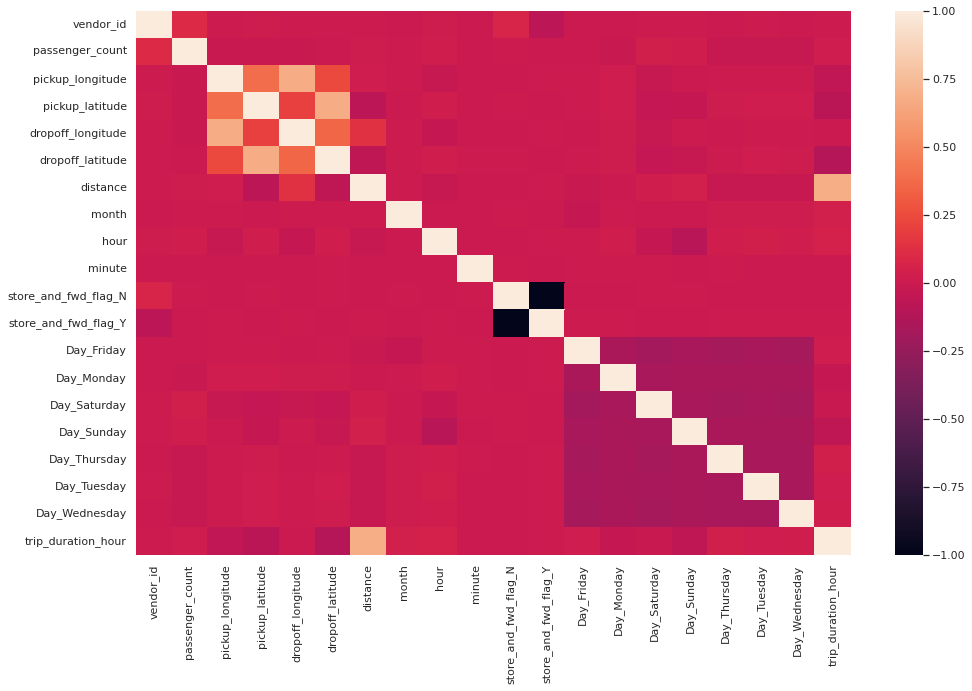

In [73]:
plt.figure (figsize= (16,10))
sns.heatmap(trip_df.corr())

In [74]:
reg = LinearRegression().fit(X_train, y_train)

In [75]:
reg.score(X_train, y_train)

0.49716367542307255

In [76]:
y_pred_train = reg.predict(X_train)

In [77]:
y_pred_test = reg.predict(X_test)

In [78]:
#Train set metrics
Ltr_MSE  = mean_squared_error((y_train), (y_pred_train))
print("MSE :" , Ltr_MSE)

Ltr_RMSE = np.sqrt(Ltr_MSE)

print("RMSE :" ,Ltr_RMSE)

Ltr_r2 = r2_score((y_train), (y_pred_train))
print("R2 :" ,Ltr_r2)
Ltr_ar2 = 1-(1-r2_score((y_train), (y_pred_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1))
print("Adjusted R2 : ",Ltr_ar2)

MSE : 0.00552027897112739
RMSE : 0.07429857987288445
R2 : 0.4971636754230726
Adjusted R2 :  0.497044221932613


In [79]:
#Test set metrics
Lte_MSE  = mean_squared_error((y_test), (y_pred_test))
print("MSE :" , Lte_MSE)

Lte_RMSE = np.sqrt(Lte_MSE)
print("RMSE :" ,Lte_RMSE)

Lte_r2 = r2_score((y_test), (y_pred_test))
print("R2 :" ,Lte_r2)
Lte_ar2 = 1-(1-r2_score((y_test), (y_pred_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R2 : ",Lte_ar2)

MSE : 0.005547404778995184
RMSE : 0.07448090210916611
R2 : 0.4983799184086748
Adjusted R2 :  0.4979029023150695


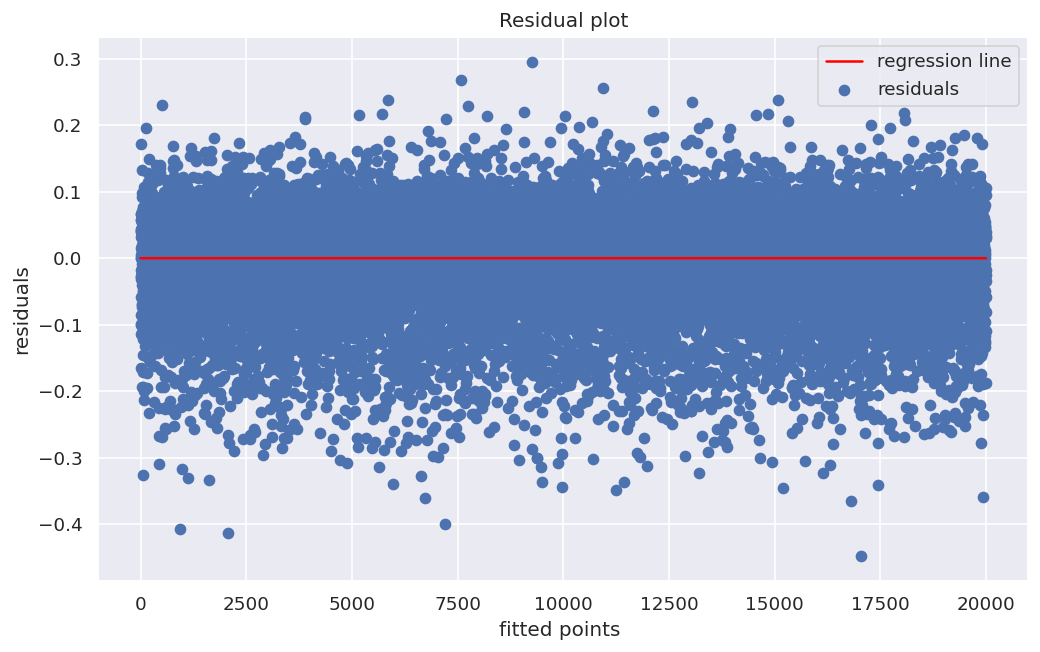

In [80]:
#Heteroskedasticity
residuals=y_pred_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

#**DecisionTree Regressor**

In [81]:
# Maximum depth of trees
max_depth = [4,6,8,10]

# Minimum number of samples required to split a node
min_samples_split = [10,20,30]

# Minimum number of samples required at each leaf node
min_samples_leaf = [10,16,20]

# HYperparameter Grid
param_dt = {
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [83]:
dt_model = DecisionTreeRegressor()

# Grid search
dt_grid = GridSearchCV(estimator=dt_model,
                       param_grid = param_dt,
                       cv = 5, verbose=2, scoring='r2')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=10 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=10, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min_samples_split=20 ..........
[CV]  max_depth=4, min_samples_leaf=10, min_samples_split=20, total=   0.2s
[CV] max_depth=4, min_samples_leaf=10, min

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [10, 16, 20],
                         'min_samples_split

In [84]:
dt_grid.best_score_

0.6080931008048771

In [85]:
dt_grid.best_score_

0.6080931008048771

In [86]:
dt_grid.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=20, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [87]:
dt_optimal_model =dt_grid.best_estimator_

In [88]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

In [89]:
y_pred_dt_test=dt_optimal_model.predict(X_test)
y_pred_dt_train=dt_optimal_model.predict(X_train)

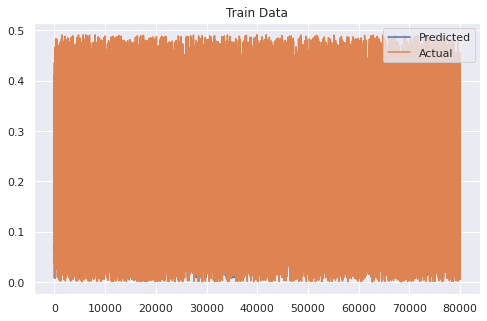

In [90]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_dt_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [91]:
MSE  = mean_squared_error(y_train, y_pred_dt_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_dt_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_dt_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.003903026546923643
Train RMSE : 0.0624742070531803
Train R2 : 0.6444774740830809
Train Adjusted R2 :  0.644393016368747


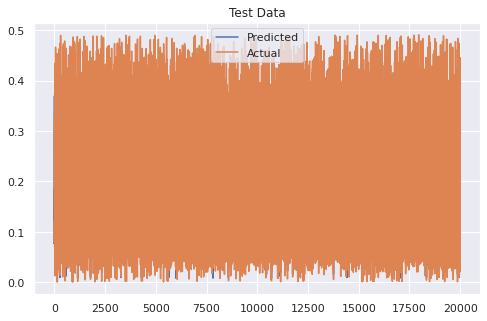

In [92]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_dt_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [93]:
MSE  = mean_squared_error(y_test, y_pred_dt_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_dt_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_dt_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.004354489573938102
Test RMSE : 0.0659885563862258
Test R2 : 0.6062484166221138
Test Adjusted R2 :  0.6058739781794622


In [94]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [95]:
dt_optimal_model.feature_importances_

array([1.16394684e-03, 2.84225785e-04, 7.69536687e-03, 6.44707689e-03,
       1.09322142e-02, 5.55127554e-02, 7.92680254e-01, 8.65285656e-04,
       8.87436813e-02, 2.25127539e-03, 0.00000000e+00, 0.00000000e+00,
       8.54379822e-04, 1.66612851e-03, 1.27086837e-02, 1.65381894e-02,
       5.62488810e-04, 3.97080317e-04, 6.96967711e-04])

In [96]:
importances = dt_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [97]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)
importance_df

Feature  Feature Importance
0              vendor_id                0.00
1        passenger_count                0.00
2       pickup_longitude                0.01
3        pickup_latitude                0.01
4      dropoff_longitude                0.01
5       dropoff_latitude                0.06
6               distance                0.79
7                  month                0.00
8                   hour                0.09
9                 minute                0.00
10  store_and_fwd_flag_N                0.00
11  store_and_fwd_flag_Y                0.00
12            Day_Friday                0.00
13            Day_Monday                0.00
14          Day_Saturday                0.01
15            Day_Sunday                0.02
16          Day_Thursday                0.00
17           Day_Tuesday                0.00
18         Day_Wednesday                0.00

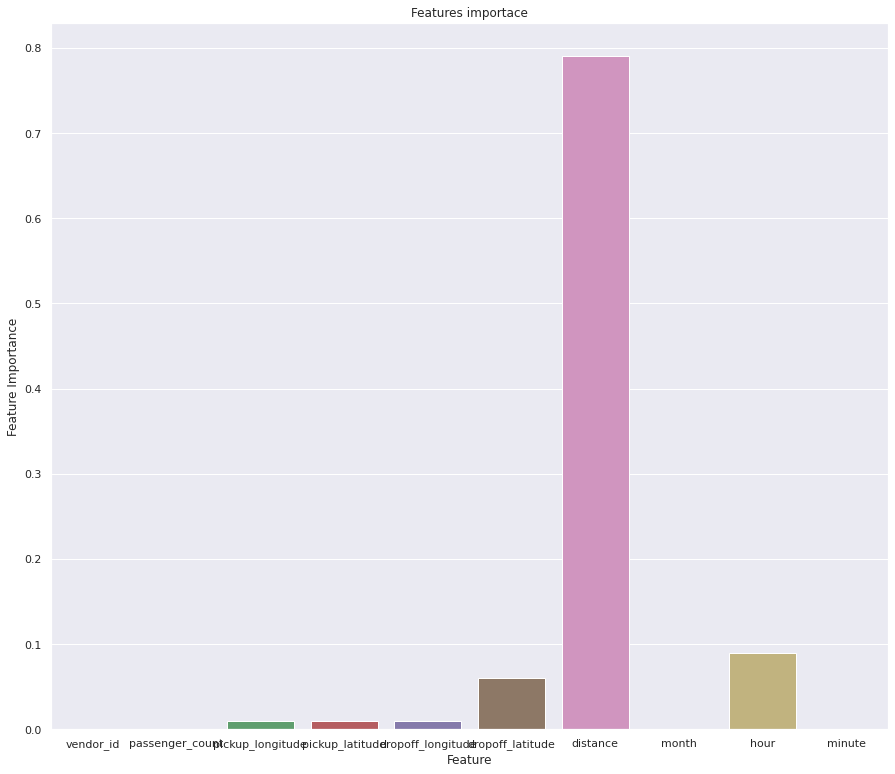

In [98]:
plt.figure(figsize=(15,13))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

#**Visualising the DT**

In [99]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

#**Applying Lasso Regression to our DataSet**

In [100]:
from sklearn.model_selection import GridSearchCV
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [101]:
lasso_regressor.score(X_train, y_train)

0.49716557121777893

In [102]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-05}

Using  {'alpha': 1e-05}  the negative mean squared error is:  0.4968581523584392


In [103]:
y_pred_lasso = lasso_regressor.predict(X_test)
y_pred_lasso_train = lasso_regressor.predict(X_train)

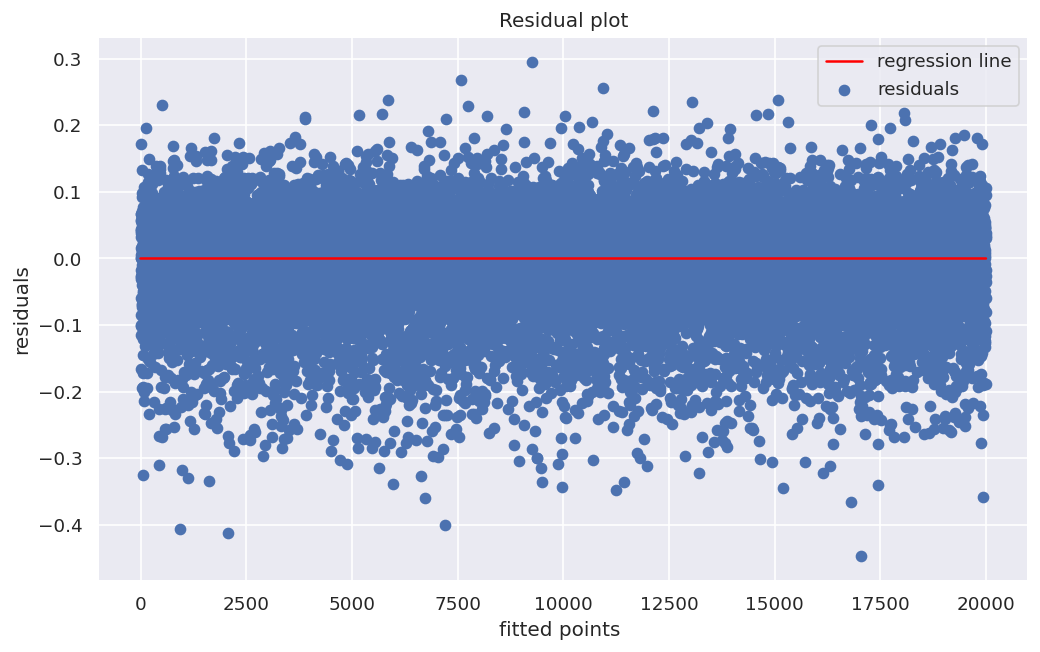

In [104]:
#Heteroskedasticity
residuals=y_pred_lasso-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

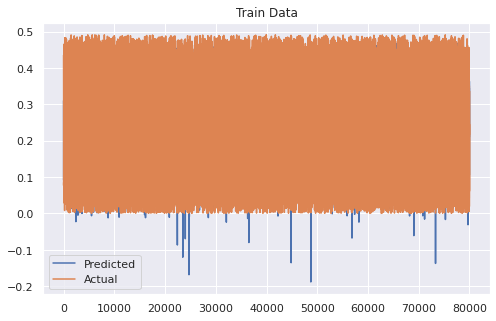

In [105]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_lasso_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [106]:
MSE  = mean_squared_error(y_train, y_pred_lasso_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_lasso_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_lasso_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.00552025815855849
Train RMSE : 0.0742984398124112
Train R2 : 0.49716557121777893
Train Adjusted R2 :  0.4970461181776832


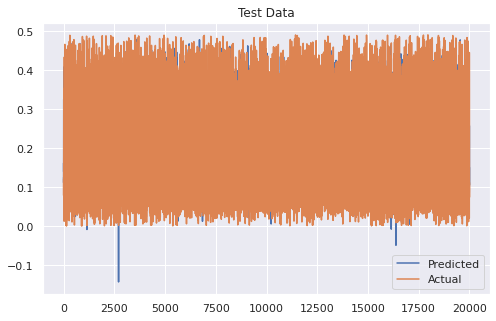

In [107]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_lasso)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [108]:
MSE  = mean_squared_error(y_test, y_pred_lasso)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_lasso)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_lasso))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.005547254775022398
Test RMSE : 0.07447989510614525
Test R2 : 0.4983934824098727
Test Adjusted R2 :  0.4979164792149672



#**Applying Ridge Regression to our DataSet**

In [109]:
from sklearn.linear_model import Ridge
### Cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [110]:
ridge_regressor.score(X_train, y_train)

0.4971656850613645

In [111]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 30}

Using  {'alpha': 30}  the negative mean squared error is:  0.4968581523584392


In [112]:
y_pred_ridge_test = ridge_regressor.predict(X_test)
y_pred_ridge_train=ridge_regressor.predict(X_train)

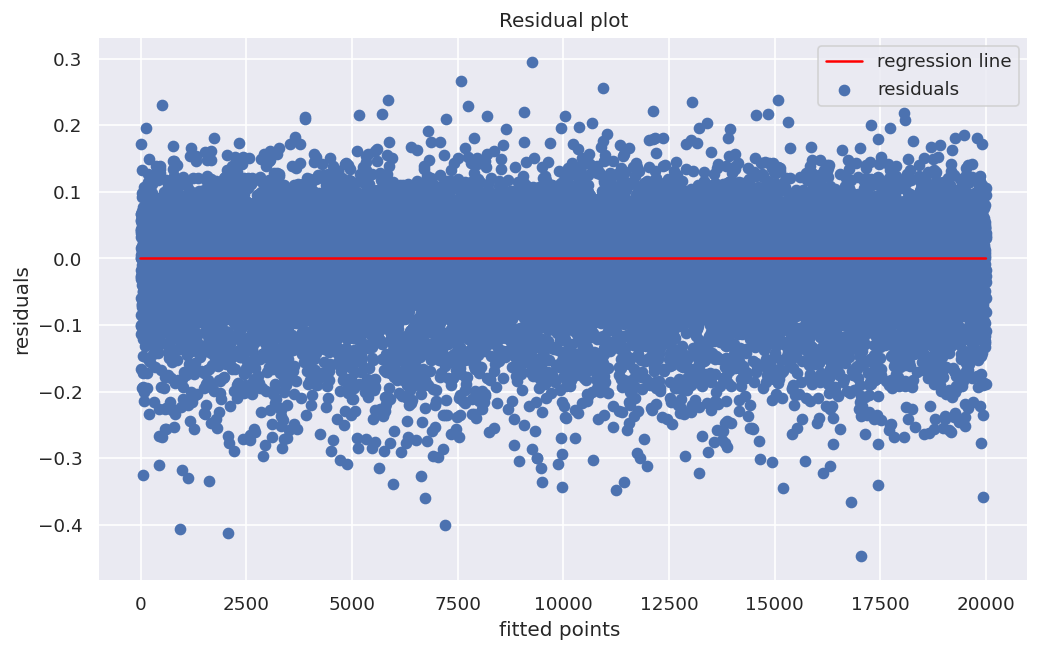

In [113]:
#Heteroskedasticity
residuals=y_pred_ridge_test-y_test

plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,len(y_test))
k = [0 for i in range(0,len(y_test))]
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

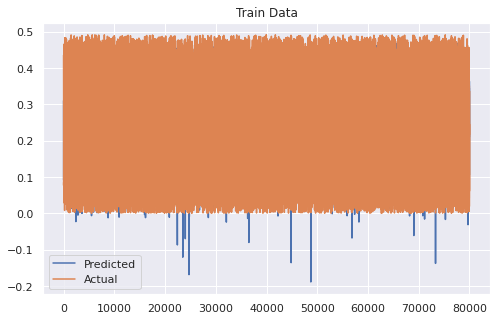

In [114]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_ridge_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [115]:
MSE  = mean_squared_error(y_train, y_pred_ridge_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_ridge_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score(y_train, y_pred_ridge_train))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.005520256908751504
Train RMSE : 0.07429843140168912
Train R2 : 0.4971656850613645
Train Adjusted R2 :  0.49704623204831333


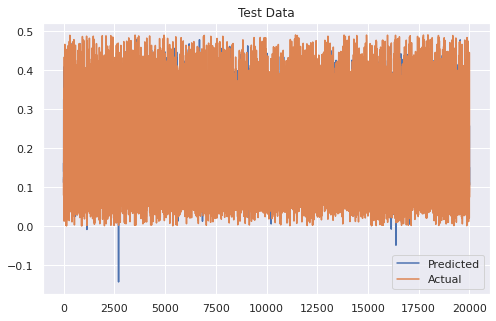

In [116]:
plt.figure(figsize=(8,5))
plt.title("Test Data")
plt.plot(y_pred_ridge_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [117]:
MSE  = mean_squared_error(y_test, y_pred_ridge_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_ridge_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score(y_test, y_pred_ridge_test))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.005547259274275785
Test RMSE : 0.07447992531062168
Test R2 : 0.49839307556812584
Test Adjusted R2 :  0.4979160719863338


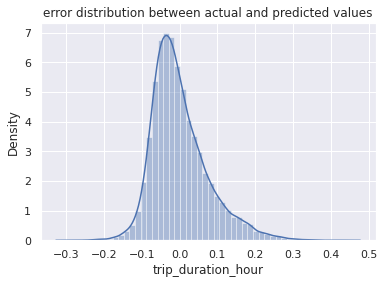

In [118]:

sns.distplot(y_test - y_pred_ridge_test ).set_title("error distribution between actual and predicted values")
plt.show()

#**Applying XGBRegressor algorithem to our DataSet**

In [119]:
# Number of trees
n_estimators = [50,100,120]

# Maximum depth of trees
max_depth = [5,7,9]
min_samples_split = [40,50]
#learning_rate=[0.1,0.3,0.5]

# HYperparameter Grid
param_xgb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
             'min_samples_split':min_samples_split
              }

In [120]:
# Create an instance of the  XGBRegressor
import xgboost as xgb
xgb_model = xgb.XGBRegressor()

# Grid search
xgb_grid = GridSearchCV(estimator=xgb_model,param_grid = param_xgb,cv = 3, verbose=2,scoring="r2")

xgb_grid.fit(X_train,y_train)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[23:48:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   4.1s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[23:48:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.8s
[CV] max_depth=5, min_samples_split=40, n_estimators=50 ..............
[23:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=50, total=   3.8s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[23:49:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.4s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[23:49:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  max_depth=5, min_samples_split=40, n_estimators=100, total=   7.4s
[CV] max_depth=5, min_samples_split=40, n_estimators=100 .............
[23:49:19] WARNING: /workspace/src/objective/

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  9.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 7, 9], 'min_samples_split': [40, 50],
                         'n_estimators': [50, 100, 1

In [121]:
xgb_grid.best_score_

0.7033838015984996

In [122]:
xgb_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 120}

In [123]:
xgb_optimal_model =xgb_grid.best_estimator_

In [124]:
y_pred_xgb_test=xgb_optimal_model.predict(X_test)
y_pred_xgb_train=xgb_optimal_model.predict(X_train)

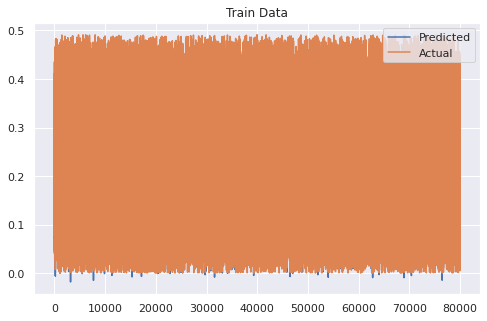

In [125]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_xgb_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [126]:
MSE  = mean_squared_error(y_train, y_pred_xgb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_xgb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_xgb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.001990850702399407
Train RMSE : 0.044618950036945146
Train R2 : 0.8186555325896028
Train Adjusted R2 :  0.8186124525085725


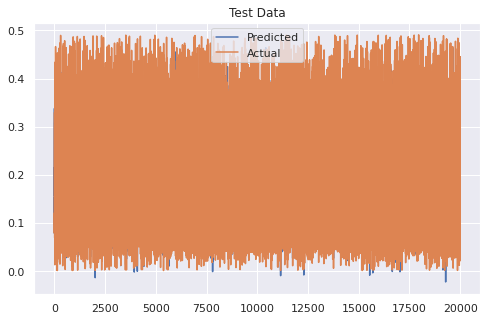

In [127]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_pred_xgb_test)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [128]:
MSE  = mean_squared_error(y_test, y_pred_xgb_test)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_pred_xgb_test)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_pred_xgb_test)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.0032639168965066688
Test RMSE : 0.05713070012267195
Test R2 : 0.7048626654877816
Test Adjusted R2 :  0.7045820043588662


In [129]:
X_train.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'month', 'hour',
       'minute', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'Day_Friday',
       'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [130]:
xgb_optimal_model.feature_importances_

array([0.00604962, 0.00559954, 0.01959756, 0.01960055, 0.02295835,
       0.0407939 , 0.44438186, 0.01952472, 0.08113966, 0.01054253,
       0.00686696, 0.        , 0.0184279 , 0.05178199, 0.07336915,
       0.1075487 , 0.02511282, 0.02252647, 0.02417778], dtype=float32)

In [131]:
importances = xgb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)


In [132]:
importance_df['Feature Importance'] = round(importance_df['Feature Importance'],2)

In [133]:
importance_df

Feature  Feature Importance
0              vendor_id                0.01
1        passenger_count                0.01
2       pickup_longitude                0.02
3        pickup_latitude                0.02
4      dropoff_longitude                0.02
5       dropoff_latitude                0.04
6               distance                0.44
7                  month                0.02
8                   hour                0.08
9                 minute                0.01
10  store_and_fwd_flag_N                0.01
11  store_and_fwd_flag_Y                0.00
12            Day_Friday                0.02
13            Day_Monday                0.05
14          Day_Saturday                0.07
15            Day_Sunday                0.11
16          Day_Thursday                0.03
17           Day_Tuesday                0.02
18         Day_Wednesday                0.02

In [134]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)

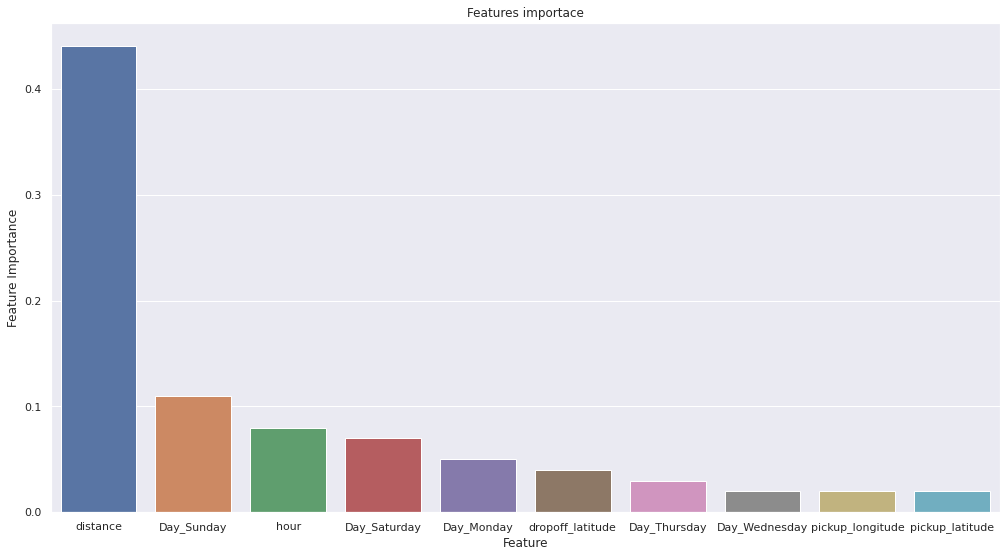

In [135]:
plt.figure(figsize=(17,9))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])

#**Applying GradientBoosting Algorithem to our DataSet**

In [136]:
# Number of trees
n_estimators = [100,120]

# Maximum depth of trees
max_depth = [5,8,10]

# Minimum number of samples required to split a node
min_samples_split = [50,80]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]


# HYperparameter Grid
param_gb = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [137]:
# Create an instance of the  GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_model=GradientBoostingRegressor()

# Grid search
gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid = param_gb,
                       cv = 3, verbose=2, scoring='r2')

gb_grid.fit(X_train,y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  20.9s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.9s remaining:    0.0s


[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  20.7s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=  20.6s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  24.9s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  24.8s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=50, n_estimators=120, total=  24.8s
[CV] max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100 
[CV]  max_depth=5, min_samples_leaf=40, min_samples_split=80, n_estimators=100, total=  20.7s
[CV] max_depth=5, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 40.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...ge=None,
                    

In [138]:
gb_grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 50,
 'min_samples_split': 50,
 'n_estimators': 120}

In [139]:
gb_grid.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=10,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=50,
                          min_weight_fraction_leaf=0.0, n_estimators=120,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [140]:
gb_optimal_model = gb_grid.best_estimator_

In [141]:
y_preds_gb = gb_optimal_model.predict(X_test)
y_pred_gb_train=gb_optimal_model.predict(X_train)

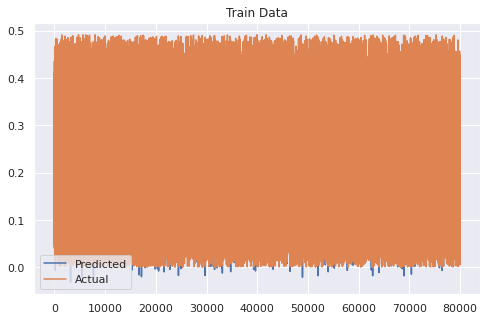

In [142]:
plt.figure(figsize=(8,5))
plt.title('Train Data')
plt.plot(y_pred_gb_train)
plt.plot(np.array(y_train))
plt.legend(["Predicted","Actual"])
plt.show()

In [143]:
MSE  = mean_squared_error(y_train, y_pred_gb_train)
print("Train MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Train RMSE :" ,RMSE)

r2 = r2_score(y_train, y_pred_gb_train)
print("Train R2 :" ,r2)
print("Train Adjusted R2 : ",1-(1-r2_score((y_train), (y_pred_gb_train)))*((X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)))

Train MSE : 0.002323670139456396
Train RMSE : 0.048204461821043036
Train R2 : 0.7883393649914061
Train Adjusted R2 :  0.7882890830200988


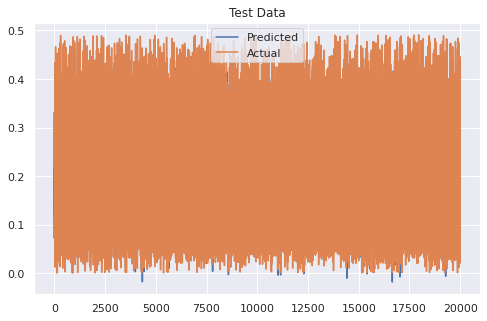

In [144]:
plt.figure(figsize=(8,5))
plt.title('Test Data')
plt.plot(y_preds_gb)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [145]:
MSE  = mean_squared_error(y_test, y_preds_gb)
print("Test MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("Test RMSE :" ,RMSE)

r2 = r2_score(y_test, y_preds_gb)
print("Test R2 :" ,r2)
print("Test Adjusted R2 : ",1-(1-r2_score((y_test), (y_preds_gb)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

Test MSE : 0.003268332446055223
Test RMSE : 0.05716933134168374
Test R2 : 0.704463392600178
Test Adjusted R2 :  0.7041823517823304


In [146]:
xgb_optimal_model.feature_importances_

array([0.00604962, 0.00559954, 0.01959756, 0.01960055, 0.02295835,
       0.0407939 , 0.44438186, 0.01952472, 0.08113966, 0.01054253,
       0.00686696, 0.        , 0.0184279 , 0.05178199, 0.07336915,
       0.1075487 , 0.02511282, 0.02252647, 0.02417778], dtype=float32)

In [147]:
importances = gb_optimal_model.feature_importances_

importance_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : importances}

importance_df = pd.DataFrame(importance_dict)

In [148]:
importance_df['Feature Importance'] = importance_df['Feature Importance']
importance_df

Feature  Feature Importance
0              vendor_id            0.001806
1        passenger_count            0.000678
2       pickup_longitude            0.040979
3        pickup_latitude            0.033463
4      dropoff_longitude            0.043920
5       dropoff_latitude            0.073518
6               distance            0.661889
7                  month            0.007782
8                   hour            0.088536
9                 minute            0.006882
10  store_and_fwd_flag_N            0.000000
11  store_and_fwd_flag_Y            0.000000
12            Day_Friday            0.001848
13            Day_Monday            0.004856
14          Day_Saturday            0.013189
15            Day_Sunday            0.015568
16          Day_Thursday            0.001905
17           Day_Tuesday            0.001476
18         Day_Wednesday            0.001704

In [149]:
importance_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
importance_df

Feature  Feature Importance
6               distance            0.661889
8                   hour            0.088536
5       dropoff_latitude            0.073518
4      dropoff_longitude            0.043920
2       pickup_longitude            0.040979
3        pickup_latitude            0.033463
15            Day_Sunday            0.015568
14          Day_Saturday            0.013189
7                  month            0.007782
9                 minute            0.006882
13            Day_Monday            0.004856
16          Day_Thursday            0.001905
12            Day_Friday            0.001848
0              vendor_id            0.001806
18         Day_Wednesday            0.001704
17           Day_Tuesday            0.001476
1        passenger_count            0.000678
11  store_and_fwd_flag_Y            0.000000
10  store_and_fwd_flag_N            0.000000

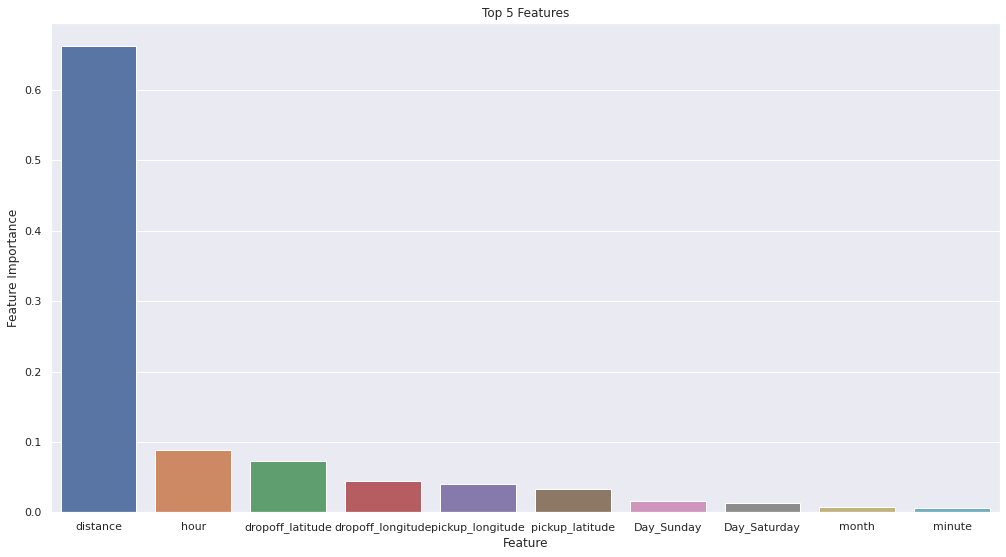

In [150]:
plt.figure(figsize=(17,9))
plt.title('Top 5 Features')
sns.barplot(x='Feature',y="Feature Importance",data=importance_df[:10])